# cosmoglobe tutorial

Begin by importing some useful libraries:

In [1]:
import astropy.units as u
import healpy as hp
import numpy as np
import pathlib

To view plots inside the Jupyter Notebook:

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## Initialize a sky model from a commander3 Gibbs chain

In this example we set the path to the chain file using the pathlib library

In [3]:
from cosmoglobe.sky import model_from_chain

chain_dir = pathlib.Path("/Users/metinsan/Documents/doktor/Cosmoglobe_test_data/")
chain = chain_dir / "chain_test.h5"

Initialize the model at a given `NSIDE`, for example `NSIDE=256`

In [4]:
# Reads alms and maps from the chain and initializes the sky model
model = model_from_chain(chain, nside=256)

Loading components from chain
Done: 100%|██████████| 6/6 [00:05<00:00,  1.17it/s] 


We can inspect the model by printing the model object. This shows us the individual sky component's included in the model and their associated spectral parameters.

In [5]:
model

Model(
  nside: 256
  components( 
    (dust): Dust(beta, T)
    (synch): Synchrotron(beta)
    (ff): FreeFree(Te)
    (ame): AME(nu_p)
    (cmb): CMB()
    (radio): Radio(specind)
  )
)

## Model components

Let us explore the sky components in further detail. Each component is stored as a model attribute with attribute names seen in the parenthesis in the model `__repr__`.

In [6]:
print(model.dust)
print(model.synch)

Dust(beta, T)
Synchrotron(beta)


### Component attributes

Each component has the following attributes:

- `amp`: Amplitude map at a given reference frequency. Its shape is (3, `npix`) if the component is polarized and (1,`npix`) if else.

- `freq_ref`: Reference frequency of the component.

- `spectral_parameters`: A Dictionary containing the spectral parameters.

In [7]:
# Note: most maps and other quantities are astropy.Quantity objects
print(model.dust.amp)
print(model.dust.freq_ref)
print(model.dust.spectral_parameters)

[[30.309875   -0.4310924   8.452302   ...  6.667059    9.971937
  11.81585   ]
 [-4.019577   -1.2983557   1.6992227  ...  4.3319874  -5.6275396
   0.72578835]
 [ 2.6104844   2.118119   -0.9043058  ... -6.7324114   0.4760493
   0.7606246 ]] uK
[[545.]
 [353.]
 [353.]] GHz
{'beta': <Quantity [[1.5476462],
           [1.5766188],
           [1.5766188]]>, 'T': <Quantity [[17.331007],
           [17.331007],
           [17.331007]] K>}


We can visualize `amp` using healpy:

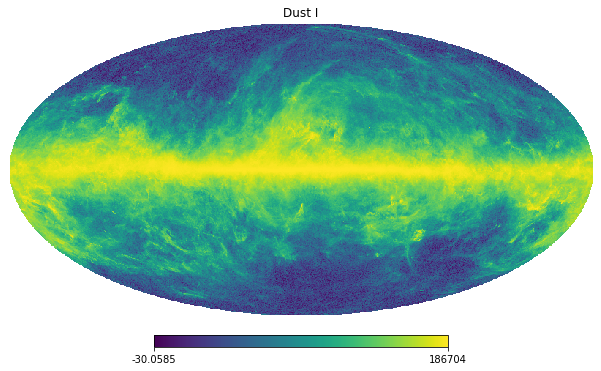

In [8]:
hp.mollview(
    model.dust.amp[0], # Stokes I
    title='Dust I',
    norm='hist',
)

Similarly for Stokes Q:

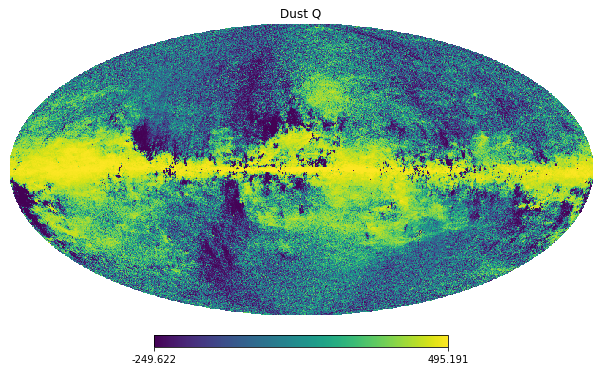

In [9]:
hp.mollview(
    model.dust.amp[1], # Stokes Q
    title='Dust Q',
    norm='hist', 
)

## Simulations

We can simulate the emission from a component at some other frequency by calling the component's `__call__` method:

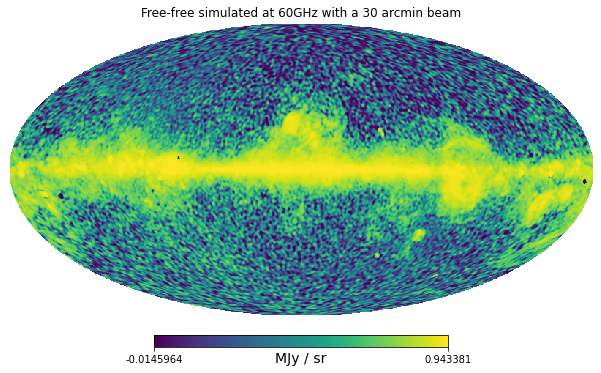

In [10]:
# Simulated free free emission at 60GHz seen by a 30 arcmin beam in units of MJy/sr
ff_60GHz = model.ff(60*u.GHz, fwhm=30*u.arcmin, output_unit='MJy/sr')

hp.mollview(
    ff_60GHz[0], 
    title=f'Free-free simulated at 60GHz with a 30 arcmin beam', 
    norm='hist', 
    unit=ff_60GHz.unit
)

## Full sky model emission 

Similarly, by calling the model's `__call__` function, we can simulate the sky emission over the full model at a given frequency:

100%|██████████| 12192/12192 [00:02<00:00, 5133.29it/s]
Smoothing diffuse emission


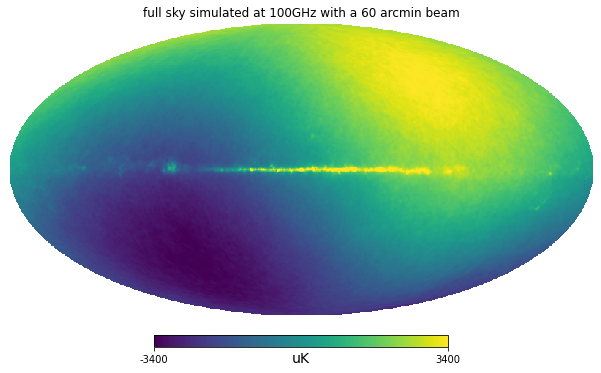

In [11]:
# Simulated full sky emission at 100GHz seen by a 60 arcmin beam in units of uK_RJ
fullsky_emission_100GHz = model(100*u.GHz, fwhm=60*u.arcmin)

hp.mollview(
    fullsky_emission_100GHz[0], 
    title=f'full sky simulated at 100GHz with a 60 arcmin beam', 
    norm='hist', 
    min=-3400,
    max=3400,
    unit=fullsky_emission_100GHz.unit # by default, all emissions will have units of uK_RJ
)


Without the solar dipole:

100%|██████████| 12192/12192 [00:02<00:00, 5126.69it/s]
Smoothing diffuse emission


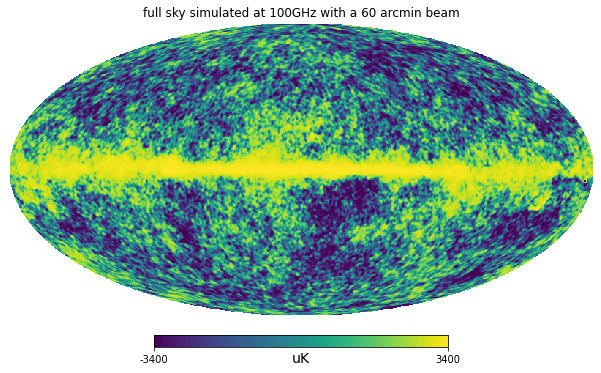

In [12]:
# Remove the solar dipole
model.cmb.remove_dipole()

# Simulated full sky emission at 100GHz seen by a 60 arcmin beam in units of uK_RJ
fullsky_emission_100GHz = model(100*u.GHz, fwhm=60*u.arcmin)

hp.mollview(
    fullsky_emission_100GHz[0], 
    title=f'full sky simulated at 100GHz with a 60 arcmin beam', 
    norm='hist', 
    min=-3400,
    max=3400,
    unit=fullsky_emission_100GHz.unit
)

## Bandpass integration

We can also make simulations over a given bandpass. In the following example we use the WMAP K-band bandpass profile:

In [13]:
bandpass = chain_dir / "wmap_bandpass.txt"

frequencies, bandpass, _ = np.loadtxt(bandpass, unpack=True)
#add astropy units
frequencies*= u.GHz
bandpass *= u.K

100%|██████████| 12192/12192 [00:02<00:00, 5184.82it/s]
Smoothing diffuse emission


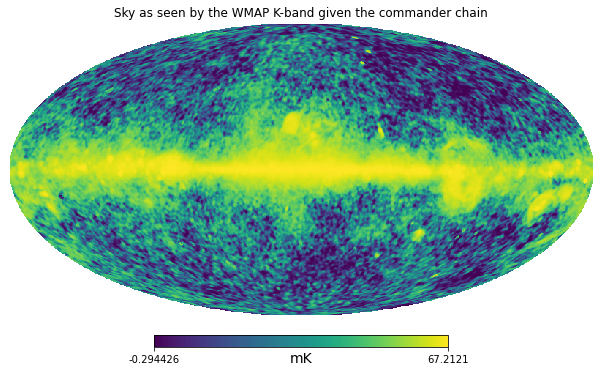

In [14]:
# WMAP observed with a beam of 0.88 degrees
wmap_fwhm = 0.88*u.deg

# Note: Solar dipole is removed from the model
wmap_kband_emission = model(frequencies, bandpass, fwhm=60*u.arcmin, output_unit='mK')

hp.mollview(
    wmap_kband_emission[0], 
    title=f'Sky as seen by the WMAP K-band given the commander chain', 
    norm='hist', 
    unit=wmap_kband_emission.unit
)

## Point sources

The radio component does not internally store amplitude maps, but rather just a single amplitude value estimated in commander per point source. Each source is mapped to a healpix map with a gaussian beam whenever the model (or radio component) is called.

100%|██████████| 12192/12192 [00:02<00:00, 5326.80it/s]


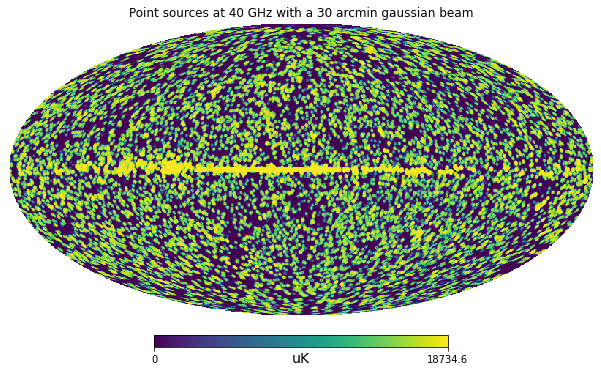

In [15]:
# Point sources seen at 40GHz over a 50 arcmin gaussian beam
radio_sources_40GHz = model.radio(30*u.GHz, fwhm=50*u.arcmin)

hp.mollview(
    radio_sources_40GHz[0], 
    title=f'Point sources at 40 GHz with a 30 arcmin gaussian beam', 
    norm='hist', 
    unit=radio_sources_40GHz.unit,
)

We can disable point sources (or any component in the model for that sake) as following:

In [16]:
model.disable('radio')

# cosmoglobe.plot

In conjuction with the Cosmoglobe sky model, we have developed software that displays sky models and components with sensible esthetique choices and other features, which we will document in another tutorial.

In [17]:
from cosmoglobe.plot import plot

Colormap: sunburst
Applying semi-logscale


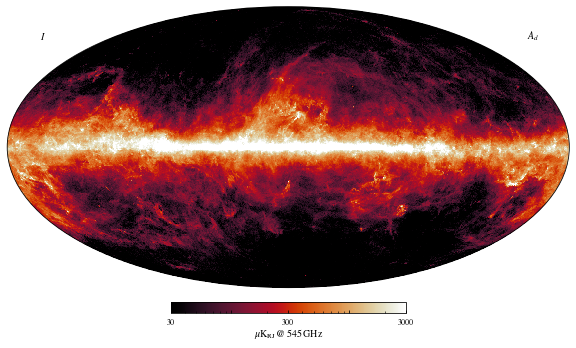

In [18]:
# Thermal dust I amplitude at the reference frequency
plot(model, comp='dust')

Colormap: freeze
Applying semi-logscale


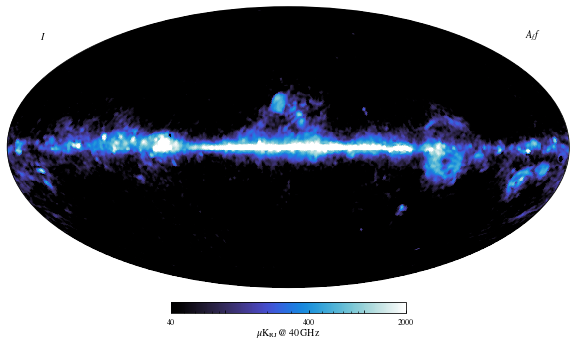

In [19]:
# Free-free I amplitude with a 40 arcmin beam
plot(model, comp='ff', fwhm=40*u.arcmin)

Colormap: amber
Applying semi-logscale


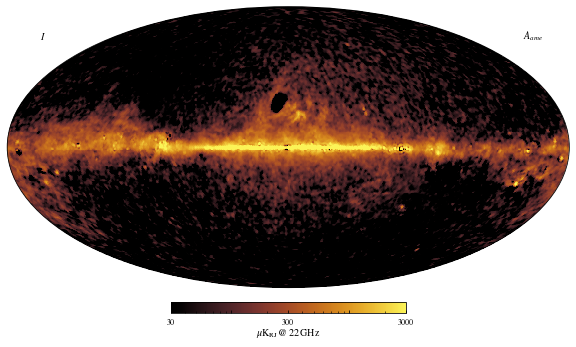

In [20]:
# AME I amplitude with a 40 arcmin beam 
plot(model, comp='ame', fwhm=40*u.arcmin)

/opt/anaconda3/envs/cosmoglobe_test/lib/python3.8/site-packages/cosmoglobe/plot/plottools.py:296: UserWarning: Input frequency is different from reference, autosetting ticks
  warnings.warn(f'Input frequency is different from reference, autosetting ticks')


input: 50.0 GHz, reference: 0.408
Colormap: swamp
Applying semi-logscale


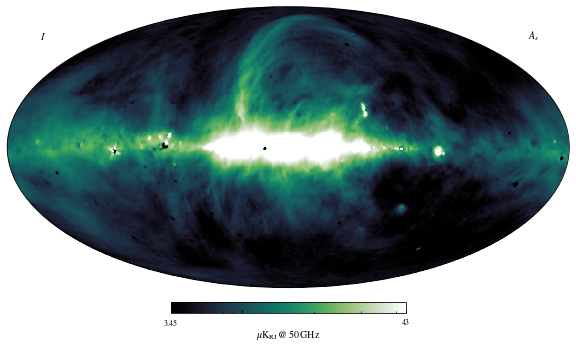

In [21]:
# Synchrotron I amplitude at 40 GHz with a 40 arcmin beam
plot(model, comp='synch', freq=50*u.GHz, fwhm=40*u.arcmin)

100%|██████████| 12192/12192 [00:02<00:00, 5741.63it/s]
input: 100.0 GHz, reference: 30.0
Colormap: CMRmap
Applying semi-logscale


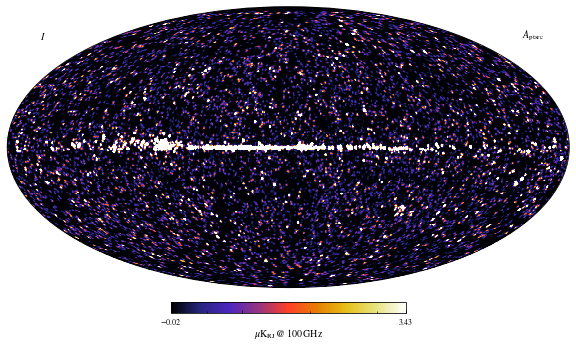

In [22]:
# Point source amplitude at 100 GHz with a 30 arcmin beam
plot(model, comp='radio', freq=100*u.GHz, fwhm=30*u.arcmin)

Smoothing diffuse emission
Colormap: planck


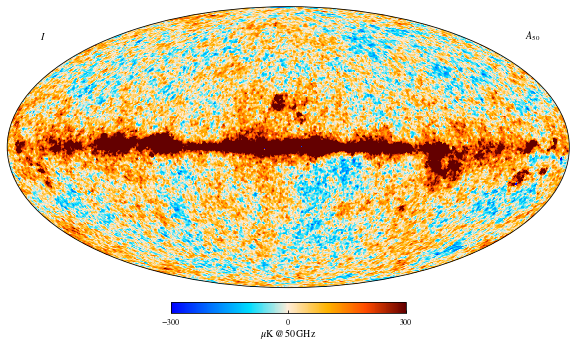

In [23]:
# Full sky intensity at 50 GHz with a 30 arcmin beam
plot(model, freq=50*u.GHz, fwhm=30*u.arcmin)